In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from sklearn.multioutput import MultiOutputRegressor
import os

%matplotlib notebook

In [2]:
def cindex(true_labels, predictions):
    n,h = 0,0
    
    for i in range(1,len(true_labels)):
        t = true_labels[i]
        p = predictions[i]
        for j in range(i+1,len(true_labels)):
            nt = true_labels[j]
            npr = predictions[j]
            if t != nt:
                n += 1
                if (p < npr and t < nt) or (p > npr and t > nt):
                    h += 1
                else :
                    h += 0.5
                    
    return h/n

In [3]:
# load data c
filename_c = []
list_c = os.listdir('../data/c_prepared_data')
for f in list_c:
    if "all" in f:
        filename_c.append(f)

df_c = pd.DataFrame()
for f in filename_c:
    df1 = pd.read_csv("../data/c_prepared_data/"+f)
    df_c=df_c.append(df1)

#display(df_c)

In [4]:
# load data j
filename_j = []
list_j = os.listdir('../data/j_prepared_data')
for f in list_j:
    if "all" in f:
        filename_j.append(f)



df_j = pd.DataFrame()
for f in filename_j:
    df2 = pd.read_csv("../data/j_prepared_data/"+f)
    df_j=df_j.append(df2)

#display(df_j)

In [5]:
# load data jj

filename_jj = []
list_jj = os.listdir('../data/jj_prepared_data')
for f in list_jj:
    if "all" in f:
        filename_jj.append(f)



df_jj = pd.DataFrame()
for f in filename_jj:
    df3 = pd.read_csv("../data/jj_prepared_data/"+f)
    df_jj=df_jj.append(df3)

#display(df_jj)

# All data combined to one big dataframe, using KFold CV

In [6]:
df_all=df_c.append(df_j)
df_all=df_all.append(df_jj).dropna(axis=1)

In [7]:
df_all= df_all.sample(frac=1).reset_index()

In [8]:
df_all

,index,mxamp,std,skew,kurtosis,aimean,lasimean,aistd,lasistd,hr,patpk,patft,sbp,dbp
0,69,2094.355350,586.616177,0.029815,-1.060248,0.257772,0.175000,0.024884,0.005000,77.669903,1.1850,0.161667,120.615000,80.212500
1,32,1677.027334,496.070554,0.219606,-1.295964,0.730186,0.080000,0.000000,0.000000,62.500000,1.3800,0.195000,115.853333,85.817500
2,72,1513.309284,361.710872,-0.668562,-0.472909,-0.048879,0.140000,0.022126,0.005000,105.571848,1.4225,0.166250,116.306000,81.716000
3,53,784.794326,207.086095,-0.299087,-0.883696,0.609704,0.057500,0.053989,0.002500,72.289157,1.2700,0.205000,94.067500,68.840000
4,16,776.565951,130.325609,0.646549,2.363293,0.472821,0.082500,0.374510,0.032500,100.840336,1.5725,1.395000,155.154000,100.530000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1309,15,986.358168,298.291412,-0.169202,-1.280877,0.361122,0.152500,0.025436,0.007500,83.044983,1.7300,0.160000,124.282500,81.835000
1310,11,296.676694,72.722249,-0.830970,-0.077822,0.116337,0.135000,0.020490,0.000000,70.588235,1.2850,0.747500,133.010000,89.713333
1311,39,1093.074567,290.869529,-1.015298,-0.202146,-0.086456,0.133750,0.059540,0.005449,106.904232,1.9650,0.179000,105.958333,73.003333
1312,26,1574.889590,461.211836,-0.007179,-1.349783,0.838132,0.045000,0.000000,0.000000,65.040650,1.2700,0.208333,115.003333,79.022500


In [9]:
features = df_all[['mxamp', 'std', 'skew','kurtosis','aimean','lasimean','aistd','lasistd','hr',  'patpk', 'patft']]

target = df_all[['sbp', 'dbp']]

# model and its current hyperparameters

model = xgb.XGBRegressor(max_depth=6, eta=0.1, gamma=0.1,learning_rate=0.03)
wrapper = MultiOutputRegressor(model)

kf = KFold(n_splits=9)
X = features.values
y = target.values


sbp_er = []
dbp_er = []
true_label = []
pred_label = []
acc_sbp = 0
acc_dbp = 0

for i, (train_idx, val_idx) in enumerate(kf.split(X)):
    X_train, X_test = X[train_idx], X[val_idx]
    y_train, y_test = y[train_idx], y[val_idx]
    
    #print(len(X_train),len(X_test))
    #print(len(y_train),len(y_test))
    
    # xgb through wrapper 
    xgbr = make_pipeline(StandardScaler(),wrapper)
    xgbr.fit(X, y)
    y_pred = xgbr.predict(X_test)
    mae_sbp = mean_absolute_error(y_pred[:,0], y_test[:,0])
    mae_dbp = mean_absolute_error(y_pred[:,1], y_test[:,1])

    if mae_sbp<= 10:
        acc_sbp = acc_sbp+1
    if mae_dbp <=10:
        acc_dbp = acc_dbp+1
        
    sbp_er.append(mae_sbp)
    dbp_er.append(mae_dbp)
    
    true_label.append(y_test)
    pred_label.append(y_pred)
    
true = [item for sublist in true_label for item in sublist]
pred = [item for sublist in pred_label for item in sublist]

true = np.array(true)
pred = np.array(pred)

cidx_sbp = cindex(true[:,0], pred[:,0])
cidx_dbp = cindex(true[:,1], pred[:,1])
    
print(f"Average MAE SBP: {np.mean(sbp_er)} MAE DBP: {np.mean(dbp_er)}")
print(f"C index SBP: {cidx_sbp}  C index DBP: {cidx_dbp}")
#print(f"Probability SBP: {acc_sbp/len(pred)}  Probability DBP: {acc_dbp/len(pred)}" )

Average MAE SBP: 6.64507897729356 MAE DBP: 4.7760300302645815
C index SBP: 0.9357785063786114  C index DBP: 0.9367486000959006


In [10]:
# results
df_xgb = pd.DataFrame({
    "true_sbp": true[:,0], 
    "pred_sbp": pred[:,0],
    "true_dbp": true[:,1],
    "pred_dbp": pred[:,1]
                       })
display(df_xgb)


,true_sbp,pred_sbp,true_dbp,pred_dbp
0,120.615000,113.579292,80.212500,75.509125
1,115.853333,110.578346,85.817500,80.961777
2,116.306000,107.850563,81.716000,75.357002
3,94.067500,90.941452,68.840000,71.015854
4,155.154000,127.117157,100.530000,88.675758
...,...,...,...,...
1309,124.282500,114.065590,81.835000,76.294930
1310,133.010000,121.148262,89.713333,84.748894
1311,105.958333,102.740730,73.003333,72.400650
1312,115.003333,105.138054,79.022500,77.081711


<IPython.core.display.Javascript object>


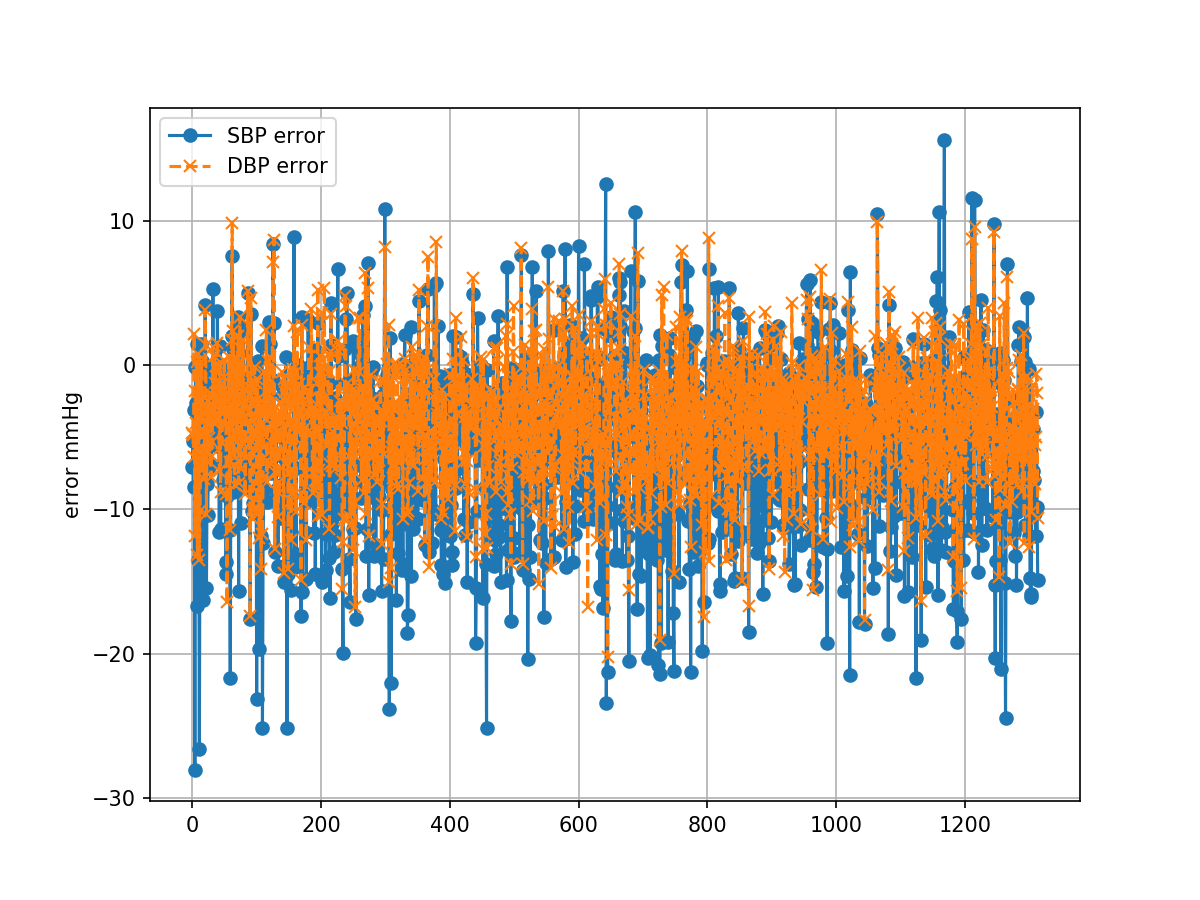

In [11]:
# plot errors
error_df=pd.DataFrame()
error_df["sbp_error"]=df_xgb['pred_sbp']-df_xgb['true_sbp']
error_df["dbp_error"]=df_xgb['pred_dbp']-df_xgb['true_dbp']

y=error_df["sbp_error"]
x=len(error_df)

plt.figure(figsize=(8, 6))
plt.plot(error_df["sbp_error"], label="SBP error",marker='o',linestyle='-')
plt.plot(error_df["dbp_error"], label="DBP error",marker='x',linestyle='--')
plt.legend(loc="upper left")
plt.ylabel('error mmHg')
plt.grid()
plt.show()

<IPython.core.display.Javascript object>


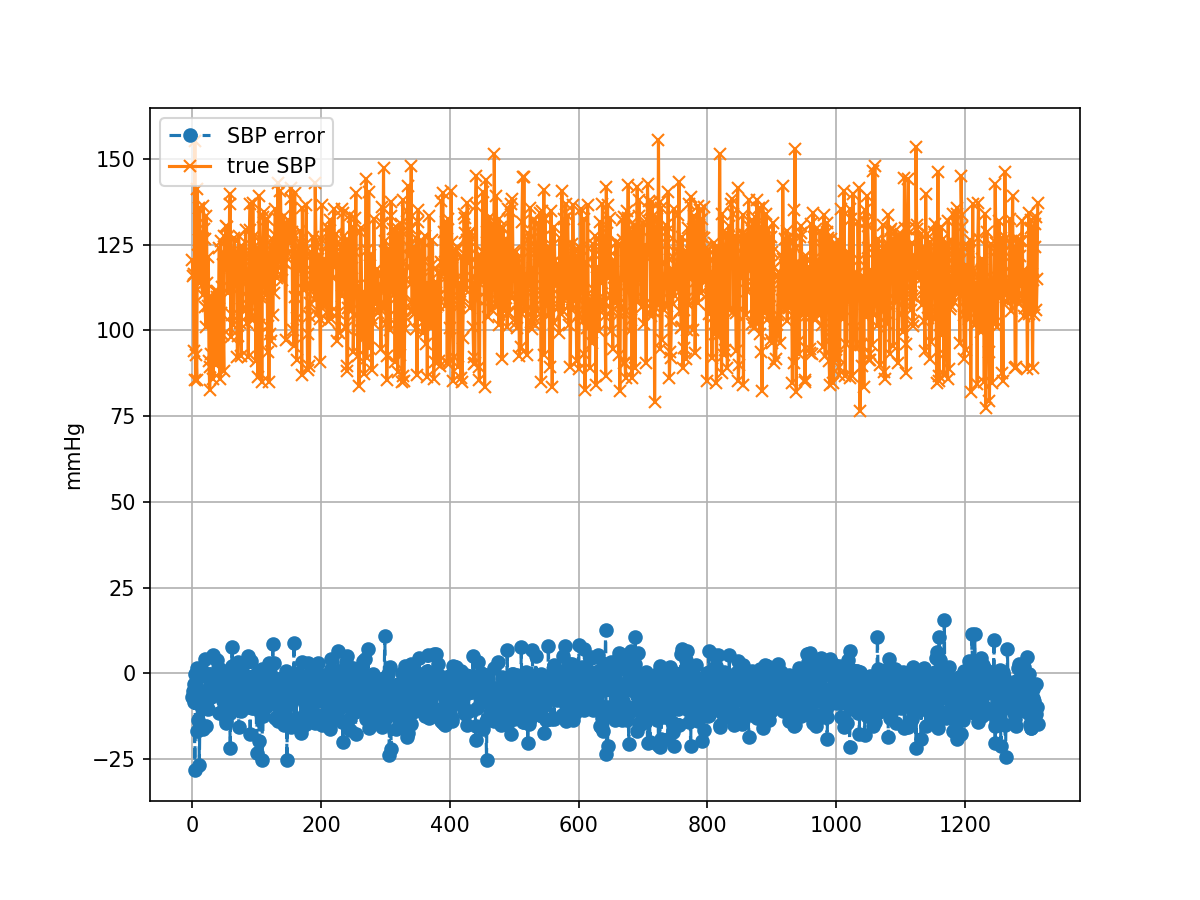

In [12]:
# plot true sbp and predicted sbp error
plt.figure(figsize=(8, 6))
plt.plot(error_df["sbp_error"], label="SBP error",marker='o',linestyle='--')
plt.plot(df_xgb['true_sbp'], label="true SBP",marker='x',linestyle='-')
plt.legend(loc="upper left")
plt.ylabel('mmHg')
plt.grid()
plt.show()

<IPython.core.display.Javascript object>


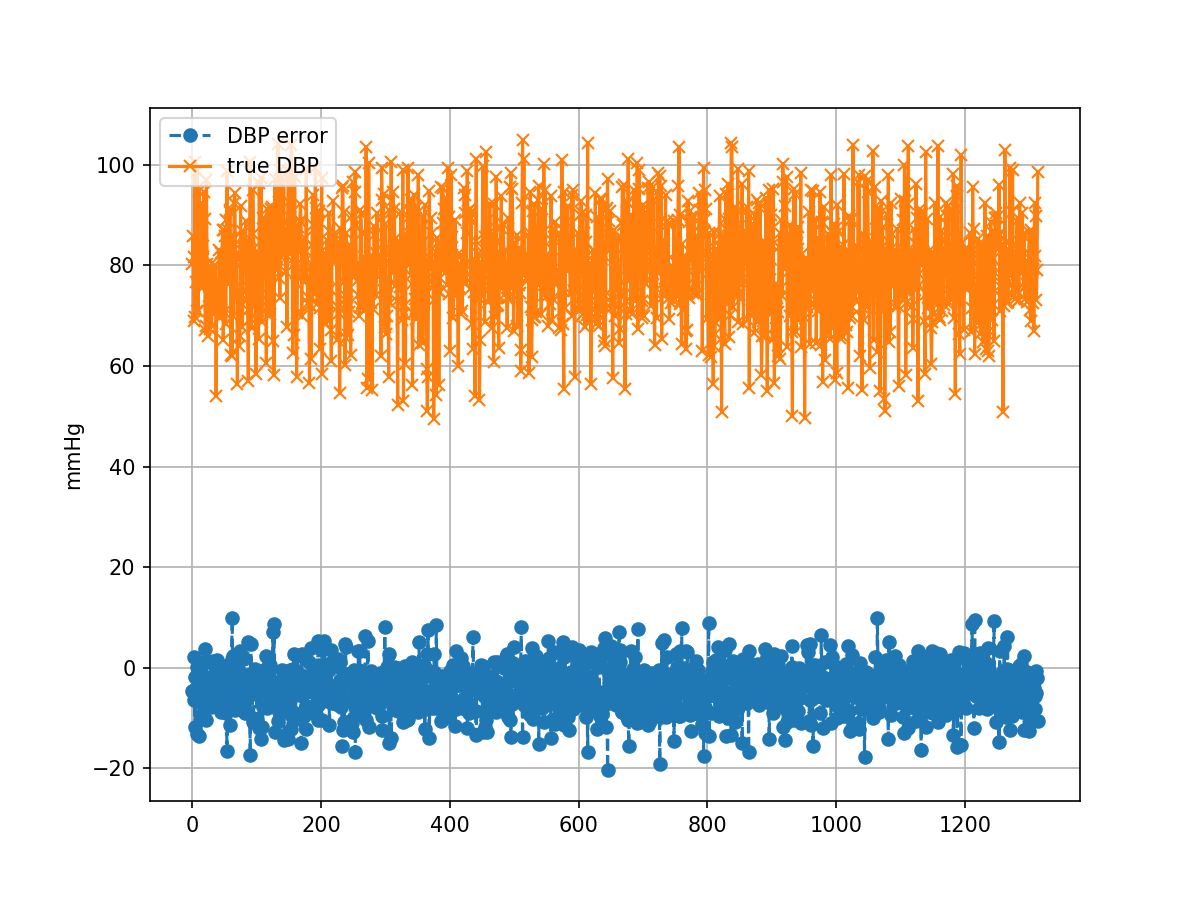

In [13]:
# plot true dbp and predicted dbp error
plt.figure(figsize=(8, 6))
plt.plot(error_df["dbp_error"], label="DBP error",marker='o',linestyle='--')
plt.plot(df_xgb['true_dbp'], label="true DBP",marker='x',linestyle='-')
plt.legend(loc="upper left")
plt.ylabel('mmHg')
plt.grid()
plt.show()

In [14]:
error_df

,sbp_error,dbp_error
0,-7.035708,-4.703375
1,-5.274987,-4.855723
2,-8.455437,-6.358998
3,-3.126048,2.175854
4,-28.036843,-11.854242
...,...,...
1309,-10.216910,-5.540070
1310,-11.861738,-4.964440
1311,-3.217603,-0.602683
1312,-9.865279,-1.940789


In [15]:
# Probabilities of less than 10 mmHg errors
# SBP, number of rows
print('total number of rows in the error dataframe:',len(error_df))

s_rows=error_df[(error_df.sbp_error.abs() <= 10)].shape[0]
print('number of sbp rows with error less than 10mmHg:',s_rows)

# DBP, number of rows
d_rows=error_df[(error_df.dbp_error.abs() <= 10)].shape[0]
print('number of dbp rows with error less than 10mmHg:',d_rows,'\n')

# probability of sbp:
prob_s=s_rows/len(error_df)

# probability of dbp:
prob_d=d_rows/len(error_df)

print('probability of SBP error less than 10mmHg =',prob_s)
print('probability of DBP error less than 10mmHg =',prob_d)

total number of rows in the error dataframe: 1314
number of sbp rows with error less than 10mmHg: 997
number of dbp rows with error less than 10mmHg: 1192 

probability of SBP error less than 10mmHg = 0.758751902587519
probability of DBP error less than 10mmHg = 0.9071537290715372
